In [1]:
import os
from glob import glob
from dataclasses import dataclass
import gc
import numpy as np
from numpy.linalg import norm
import pandas as pd
import PIL
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from transformers import ViTImageProcessor, AutoModel
from tqdm import tqdm
import xgboost as xgb
import timm

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

In [2]:
## check mac gpu availability
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS activated?: {torch.backends.mps.is_built()}")

## Apple Metal Performance Shaders(MPS) backend: maps torch ML computational graphs & primitives onto the MPS graph framework

MPS available: True
MPS activated?: True


In [3]:
@dataclass
class Config:
	device: torch.device = torch.device("mps")
	data_dir: os.PathLike = "./data/"
	n_folds: int = 4
	seed: int = 43098
	batch_size: int = 16 #32
	epochs: int = 3 #10
	eta: float = 3e-4


def RMSE(y_pred, true_value):
	"""Computes the root mean squared error."""
	return np.sqrt(mean_squared_error(y_pred, true_value))

In [4]:
## convert file extensions to lowercase
def file_ext_lowercase(path: os.PathLike):
	"""Lower case file extension."""
	for filename in os.listdir(path):
		if filename.endswith('.JPG'):
			# Generate the new filename with lowercase extension
			new_filename = os.path.join(path, filename.lower())
			# Rename the file
			os.rename(os.path.join(path, filename), new_filename)

#file_ext_lowercase(os.path.join(Config.data_dir, "train"))
#file_ext_lowercase(os.path.join(Config.data_dir, "test"))

In [5]:
train_df = pd.read_csv(os.path.join(Config.data_dir, "Train.csv"))
test_df = pd.read_csv(os.path.join(Config.data_dir, "Test.csv"))
print(f"Train data shape: {train_df.shape}, Num train images: {len(os.listdir(os.path.join(Config.data_dir, 'train')))}\n")
print(f"Train df:\n{train_df.head()}\n")
print(f"Test data shape: {test_df.shape}, Num test images: {len(os.listdir(os.path.join(Config.data_dir, 'test')))}\n")
print(f"Test df:\n{test_df.head()}")


Train data shape: (26068, 6), Num train images: 26068

Train df:
              ID                        filename growth_stage damage  extent  \
0  ID_1S8OOWQYCB  L427F01330C01S03961Rp02052.jpg            S     WD       0   
1  ID_0MD959MIZ0      L1083F00930C39S12674Ip.jpg            V      G       0   
2  ID_JRJCI4Q11V      24_initial_1_1463_1463.JPG            V      G       0   
3  ID_DBO3ZGI1GM  L341F00167C01S00324Rp14178.jpg            M     DR      60   
4  ID_ORZLWTEUUS      L1084F02394C39S13931Ip.jpg            V      G       0   

   season  
0  SR2020  
1  SR2021  
2  LR2020  
3  SR2020  
4  SR2021  

Test data shape: (8663, 5), Num test images: 8663

Test df:
              ID                         filename growth_stage damage  season
0  ID_ROOWKB90UZ   L122F00315C01S02151Rp04021.jpg            V     WD  SR2020
1  ID_PTEDRY0CYM  L1089F03254C01S08845Rp25119.jpg            F     WD  LR2021
2  ID_5WJXDV96R4   L365F01913C39S12578Rp42918.jpg            V     WD  SR2021
3  ID_DM4

In [6]:
## get only drought damaged crop images
## Since most claims are related to drought, this challenge will ask participants to predict drought damage from smartphone images of crops taken in the past.
## The Eyes-on-the-Ground project has already successfully trained models to predict drought damage in the first two seasons, but those models did not transfer well into the third season on which data are available.
#train_df = train_df[train_df["damage"].apply(lambda x: x not in ["FD", "WN"])]
#train_df.shape

Mean damage extent: 7.096056467699862
Standard Deviation of damage extent: 18.61287150126672


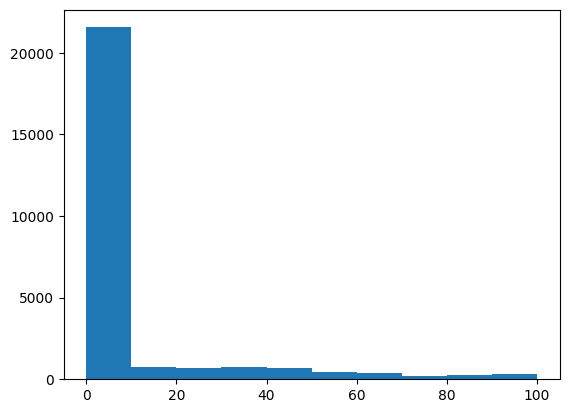

In [7]:
## extent distribution over entire dataset
print(f"Mean damage extent: {np.mean(train_df['extent'].values)}")
print(f"Standard Deviation of damage extent: {np.std(train_df['extent'].values)}")
plt.hist(train_df["extent"]);

In [8]:
# class distributions by group
groups = train_df.groupby("season")["extent"]

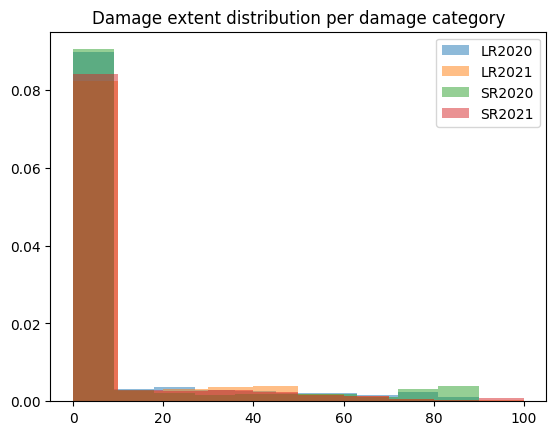

In [9]:
extent = {}
test_df["extent"] = -1
for g_name, group in groups:
	extent[g_name] = np.mean(group)

for g_name, group in groups:
	#print(f"Mean damage extent: {np.mean(group)}")
	#print(f"Standard Deviation of damage extent: {np.std(group)}")
	plt.title("Damage extent distribution per damage category")
	plt.hist(group, alpha=0.5, density=True, label=g_name)
plt.legend()

In [10]:
train_df.describe()

,extent
count,26068.000000
mean,7.096056
std,18.613229
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,100.000000


In [11]:
print(train_df['growth_stage'].value_counts())
print(train_df['season'].value_counts())

growth_stage
V    10015
M     6664
F     6164
S     3225
Name: count, dtype: int64
season
SR2021    9927
LR2021    7945
SR2020    6163
LR2020    2033
Name: count, dtype: int64


In [12]:
## dummy sub of means per damage category
## the mean extent across the entire train dataset is 15.3796 with a standard deviation of : 20.4989
## taking means per damage category yields a std of ~16.698 thus 
## therefore any model with a score significantly lower than 16.698 can be considered a fairly good predictor.

#for k, v in extent.items():
#	for r in test_df.iterrows():
#		test_df.loc[(test_df["damage"] == k), "extent"] = v

#test_df["extent"] = np.mean(train_df['extent'].values)
#test_df[["ID", "extent"]].to_csv("dummy_sub_dr.csv", index=False)

In [13]:
# match image filenames to full image path
train_df["images"] = train_df["filename"].apply(lambda x: os.path.join(Config.data_dir, "train", x))
test_df["images"] = test_df["filename"].apply(lambda x: os.path.join(Config.data_dir, "test", x))

# rename files with mismatching names.
rename_idx = list(train_df.loc[train_df["images"].apply(lambda x: "Copy" in x)].index)
for idx in rename_idx:
	corrected_fname = train_df.loc[idx, "images"].split(" - ")[0]+".jpg"
	if os.path.isfile(os.path.join(Config.data_dir, "train", corrected_fname)):
		train_df.loc[idx, "images"] = corrected_fname
	else:
		train_df.drop([idx], axis=0, inplace=True)

train_df["images"] = train_df["images"].apply(lambda x: x.replace(".JPG", ".jpg"))
test_df["images"] = test_df["images"].apply(lambda x: x.replace(".JPG", ".jpg"))
train_df = train_df.drop(["filename"], axis=1).reset_index(drop=True)
test_df = test_df.drop(["filename"], axis=1)
print(train_df.shape)

(26068, 6)


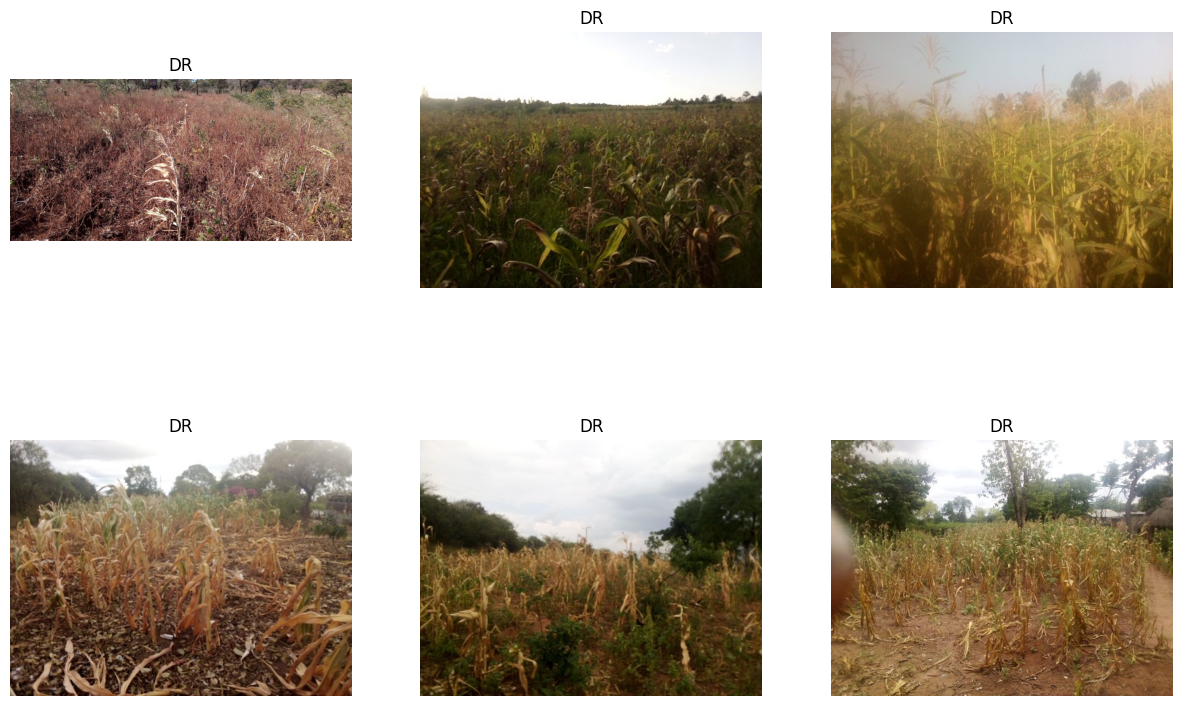

In [14]:
#print(train_df[train_df["fold"]==5]["damage"].value_counts())
def plot_images(
    df: pd.DataFrame,
    n_samples: int,
    cat: str,
    extent: int,
    seed: int,
    verbose: bool=False
):
    """Visualize a sample of images for a given damage category."""
    plot_list = df[(df["damage"] == cat) & (df["extent"] >= extent)].sample(n_samples, random_state=seed)["images"].tolist()
    if verbose:
        print(f"Sampled Image IDs:\n{plot_list}")

    labels = [cat for i in range(len(plot_list))]
    size = np.sqrt(n_samples)
    if int(size) * int(size) < n_samples:
        size = int(size) + 1

    plt.figure(figsize=(15, 15))
    for idx, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, idx + 1)
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(label, fontsize=12)
        plt.axis("off")

    plt.show()

plot_images(df=train_df, n_samples=6, cat="DR", extent=70, seed=np.random.randint(100), verbose=False)
## ND type images similar to DR, DS images
## Some PS and WD, DR images seem to have similar spatial characteristics for some extent values
## PS and G are almost indistinguishable for images further out of focus with smaller damage extents

In [263]:
## Compute image similarities to drought affected images
## use extent labels if non-DR images are very similar to drought affected images.
def cosine_similarity(emb1, emb2):
	"""Computes the cosine similarity between two embeddings."""
	cos_sim = np.dot(emb1, emb2) / (norm(emb1) * norm(emb2)) # emb1 @ emb2.T
	return cos_sim


train_embeddings = np.load("./embeddings/vit16-224_train_embeddings.npy")
non_dr_idx = list(train_df.loc[train_df["damage"].apply(lambda x: x != "DR")].index)
dr_idx = list(train_df.loc[train_df["damage"].apply(lambda x: x == "DR")].index)
#train_embeddings.shape, train_df.shape
 
def compute_similarities(embeddings, x: list, y: list):
	"""
	Compute image similarities between a given set x and a reference set y
	using the input image embeddings.
	"""
	res = {} #x_i-idx: [y_i_idx, max(<similarity score(x_i, y_i)>]
	for i in x:
		max_sim_i_j = 0
		id_j = None # the ids pair with most similar embedding
		for j in y:
			cos_sim = cosine_similarity(embeddings[i], embeddings[j])
			if cos_sim > max_sim_i_j and cos_sim > 0.85:
				max_sim_i_j = cos_sim
				id_j = j
		if id_j is not None:
			res[i] = [max_sim_i_j, id_j]

	return res

#image_similarities = compute_similarities(train_embeddings, non_dr_idx, dr_idx)

In [264]:
#for k, v in image_similarities.items():
#	train_df.loc[k, "damage"] = "DR"
#	# re-label: assign ref. image the extent value of the drought affected image it's most similar to.
#	train_df.loc[k, "extent"] = train_df.loc[v[1], "extent"]


In [15]:
train_df["damage"].value_counts()

damage
G     11623
WD     9238
DR     4516
ND      272
PS      254
DS      115
WN       37
FD       13
Name: count, dtype: int64

In [325]:
#idx = list(train_df.loc[train_df["damage"].apply(lambda x: x == "DR")].index)
#id1, id2 = 735, 970
#cos_sim = np.dot(train_embeddings[id1], train_embeddings[id2]) / (norm(train_embeddings[id1]) * norm(train_embeddings[id2]))
#print(cos_sim)
#plt.figure(figsize=(9,6))
#plt.imshow(PIL.Image.open(train_df.loc[id1, "images"]))
#plt.show()
#plt.imshow(PIL.Image.open(train_df.loc[id2, "images"]))
#plt.show()

In [16]:
## Relabel no DR damage images to 0
## greatly improves model learning ability to predict drought damaged crops
train_df.loc[(train_df["damage"] != "DR"), "extent"] = 0.0
#train_df = train_df[train_df["damage"] == "DR"].reset_index(drop=True)
train_df["extent"].value_counts()

extent
0      21558
10       729
30       727
40       696
20       690
50       445
60       388
90       300
80       291
70       199
100       45
Name: count, dtype: int64

In [17]:
## create folds
skfold = StratifiedKFold(n_splits=Config.n_folds, shuffle=True, random_state=Config.seed)
#groups = train_df["season"]
for i, (train_idx, val_idx) in enumerate(skfold.split(train_df, train_df["extent"]), 1):
	train_df.loc[val_idx, "fold"] = int(i)

train_df.head()

,ID,growth_stage,damage,extent,season,images,fold
0,ID_1S8OOWQYCB,S,WD,0,SR2020,./data/train/L427F01330C01S03961Rp02052.jpg,3.0
1,ID_0MD959MIZ0,V,G,0,SR2021,./data/train/L1083F00930C39S12674Ip.jpg,4.0
2,ID_JRJCI4Q11V,V,G,0,LR2020,./data/train/24_initial_1_1463_1463.jpg,1.0
3,ID_DBO3ZGI1GM,M,DR,60,SR2020,./data/train/L341F00167C01S00324Rp14178.jpg,3.0
4,ID_ORZLWTEUUS,V,G,0,SR2021,./data/train/L1084F02394C39S13931Ip.jpg,2.0


In [18]:
train_df["fold"].value_counts()

fold
3.0    6517
4.0    6517
1.0    6517
2.0    6517
Name: count, dtype: int64

In [19]:
#train_df["extent"] = np.log1p(train_df["extent"])
#train_df["extent"].value_counts()

### Embeddings

In [20]:
#timm.list_models()
# "vgg19", "tf_mobilenetv3_large_minimal_100"
# "vgg19_bn" "resnet50", "efficientnet_b3", "efficientnet_b4"
#  'resnext50_32x4d',
# 'resnext50d_32x4d',
# 'resnext101_32x4d',
# 'resnext101_32x8d',
# 'resnext101_32x16d',
# 'resnext101_32x32d',
# 'resnext101_64x4d',

In [21]:
#vit_model = AutoModel.from_pretrained("./vit-base-patch16-224-in21k-finetuned-cassava/")
vit_processor = ViTImageProcessor.from_pretrained("./vit-base-patch16-224-in21k-finetuned-cassava/")
swin_model = timm.create_model(
    "swin_large_patch4_window7_224", #"tf_efficientnet_b6_ns", #
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
#swin_model
#efficientnet_b4", #mobilenetv3_large_100.ra_in1k",


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [139]:
data_config = timm.data.resolve_model_data_config(tfenet_model)
data_config

{'input_size': (3, 528, 528),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.942,
 'crop_mode': 'center'}

In [140]:
#_transforms = [
#	transforms.ToTensor(),
#	transforms.RandomResizedCrop(size=(224, 224)),
#    transforms.RandomHorizontalFlip(p=0.5),
#    transforms.ToDtype(torch.float32, scale=True),
#    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#]

img = PIL.Image.open(train_df.loc[1, "images"])
#inputs = vit_processor(img, return_tensors="pt").to(Config.device)
#with torch.no_grad():
#	vit_model.to(Config.device)
#	vit_model.eval()
#	emb = torch.mean(vit_model(**inputs).last_hidden_state, 1)
#emb.shape, emb
data_config = timm.data.resolve_model_data_config(tfenet_model)
transforms = timm.data.create_transform(**data_config, is_training=False)
#transforms(image).squeeze(0)
data_config, transforms

({'input_size': (3, 528, 528),
  'interpolation': 'bicubic',
  'mean': (0.485, 0.456, 0.406),
  'std': (0.229, 0.224, 0.225),
  'crop_pct': 0.942,
  'crop_mode': 'center'},
 Compose(
     Resize(size=560, interpolation=bicubic, max_size=None, antialias=warn)
     CenterCrop(size=(528, 528))
     ToTensor()
     Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
 ))

In [332]:
#image = PIL.Image.open(train_df.loc[1, "images"]).convert("RGB") # (640, 480, 3)
# vit_processor(image)#.pixel_values[0].shape

class ImageDataset(Dataset):
	"""CGIAR maize dataset."""
	def __init__(self, data_df, processor, model, timm_data_cfg=False, verbose=False):
		self.data_df = data_df #[data_df["damage"] == self.group]
		#self.group = group # damage category
		self.processor = processor
		self.model = model
		self.timm_cfg = timm_data_cfg
		#self.transform = transforms.Compose(_transforms) # image transforms

	def __len__(self):
		return self.data_df.shape[0]

	def __getitem__(self, idx):
		image_path = self.data_df.loc[idx, "images"]
		image = PIL.Image.open(image_path).convert("RGB")
		#image = cv2.imread(image_path)
		#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		if self.timm_cfg:
			# get model specific transforms (normalization, resize)
			data_config = timm.data.resolve_model_data_config(self.model)
			transforms = timm.data.create_transform(**data_config, is_training=False)
			return transforms(image).squeeze(0)
		else:
			image = self.processor(image, return_tensors="pt").pixel_values[0]
			return image


def get_dataloaders(train_df, test_df, processor, model, batch_size, timm_data_cfg=False):
	"""Get ImageDataset data generators."""
	train_df = train_df[["images"]]
	test_df = test_df[["images"]]
	train_dataset = ImageDataset(train_df, processor, model, timm_data_cfg)
	test_dataset = ImageDataset(test_df, processor, model, timm_data_cfg)
	# create dataloaders
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
	test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

	return train_dataloader, test_dataloader


# save embeddings to disk, load via np.load(<file>)
def embeddings_to_disk(embeddings: np.ndarray, filename: str):
	"""Save embeddings to disk as numpy arrays."""
	np.save(filename+".npy", embeddings)
	return 


def get_embeddings(model, data_loader, batch_size, device, is_timm_model=False, split="train", verbose=True):
	"""Extract embeddings from input model."""
	model = model.to(device)
	model.eval()
	if split=="train":
		train_image_features = []
		for batch in tqdm(data_loader, total=len(data_loader)):
			if is_timm_model:
				with torch.no_grad():
					output = model.forward_features(batch.to(device))
					image_embeddings = model.forward_head(output, pre_logits=True)
			else:
				with torch.no_grad():
					image_embeddings = model(batch.to(device)).last_hidden_state
					image_embeddings = torch.mean(image_embeddings, 1)#.squeeze(0).detach().cpu().numpy()

			# Normalize embeddings
			#image_embeddings = F.normalize(image_embeddings, p=2.0, dim=1) # L2/euclidean norm
			image_embeddings = image_embeddings.squeeze(0).detach().cpu().numpy()
			train_image_features.extend(image_embeddings)
		train_image_features = np.array(train_image_features)
		if verbose:
			print(f"Train embeddings shape: {train_image_features.shape}")
		
		return train_image_features

	else: # split == "test"
		test_image_features = []
		for batch in tqdm(data_loader, total=len(data_loader)):
			if is_timm_model:
				with torch.no_grad():
					output = model.forward_features(batch.to(device))
					image_embeddings = model.forward_head(output, pre_logits=True)
			else:
				with torch.no_grad():
					image_embeddings = model(batch.to(device)).last_hidden_state
					image_embeddings = torch.mean(image_embeddings, 1)#.squeeze(0).detach().cpu().numpy()
			
			# Normalize embeddings
			#image_embeddings = F.normalize(image_embeddings, p=2.0, dim=1) # L2/euclidean norm
			image_embeddings = image_embeddings.squeeze(0).detach().cpu().numpy()
			test_image_features.extend(image_embeddings)

		#test_img_features = np.array(test_text_features)
		test_image_features = np.asarray(test_image_features)
		if verbose:
			print(f"Test embeddings shape: {test_image_features.shape}")

		return test_image_features


train_dataloader, test_dataloader = get_dataloaders(train_df, test_df, vit_processor, swin_model, Config.batch_size, timm_data_cfg=True)

#### Transfer Learning/DL model Finetuning

In [34]:
##
for n, p in swin_model.named_parameters():
	#if n in ["layers.0", "layers.1", "layers.2"]:
	print(n)#(layers.0)

patch_embed.proj.weight
patch_embed.proj.bias
patch_embed.norm.weight
patch_embed.norm.bias
layers.0.blocks.0.norm1.weight
layers.0.blocks.0.norm1.bias
layers.0.blocks.0.attn.relative_position_bias_table
layers.0.blocks.0.attn.qkv.weight
layers.0.blocks.0.attn.qkv.bias
layers.0.blocks.0.attn.proj.weight
layers.0.blocks.0.attn.proj.bias
layers.0.blocks.0.norm2.weight
layers.0.blocks.0.norm2.bias
layers.0.blocks.0.mlp.fc1.weight
layers.0.blocks.0.mlp.fc1.bias
layers.0.blocks.0.mlp.fc2.weight
layers.0.blocks.0.mlp.fc2.bias
layers.0.blocks.1.norm1.weight
layers.0.blocks.1.norm1.bias
layers.0.blocks.1.attn.relative_position_bias_table
layers.0.blocks.1.attn.qkv.weight
layers.0.blocks.1.attn.qkv.bias
layers.0.blocks.1.attn.proj.weight
layers.0.blocks.1.attn.proj.bias
layers.0.blocks.1.norm2.weight
layers.0.blocks.1.norm2.bias
layers.0.blocks.1.mlp.fc1.weight
layers.0.blocks.1.mlp.fc1.bias
layers.0.blocks.1.mlp.fc2.weight
layers.0.blocks.1.mlp.fc2.bias
layers.1.downsample.norm.weight
layers.1

In [26]:
torch.manual_seed(Config.seed)
torch.mps.manual_seed(Config.seed)
torch.backends.mps.deterministic=True

In [27]:
class CropImageDataset(Dataset):
	"""CGIAR crop dataset."""
	def __init__(self, data_df, model, verbose=False):
		self.data_df = data_df
		self.model = model
		self.data_config = timm.data.resolve_model_data_config(self.model)
		#self.transform = transforms.Compose(_transforms) # image transforms

	def __len__(self):
		return self.data_df.shape[0]

	def __getitem__(self, idx):
		image_path = self.data_df.loc[idx, "images"]
		image = PIL.Image.open(image_path).convert("RGB")
		# get timm model specific transforms (normalization, resize)
		transforms = timm.data.create_transform(**self.data_config, is_training=False)

		transformed_image = transforms(image).squeeze(0)
		target = torch.as_tensor(self.data_df.loc[idx, "extent"])
		cat_features = torch.as_tensor(pd.get_dummies(self.data_df[["growth_stage", "season"]]).values)

		return transformed_image, target, cat_features


def get_dataloaders(data_df, model, batch_size, shuffle=False):
	"""Get ImageDataset data generators."""
	data_df = data_df[["images", "extent", "growth_stage", "season"]]
	_dataset = CropImageDataset(data_df, model)
	dataloader = DataLoader(_dataset, batch_size=batch_size, shuffle=shuffle)

	return dataloader


class CropDamageModel(nn.Module):
	def __init__(self, model_name, out_features=1, finetune_layers=None):
		super().__init__()
		self.out_features = out_features
		self.model_name = model_name
		self.finetune_layers = finetune_layers
		self.backbone = timm.create_model(
			self.model_name, #"swin_large_patch4_window7_224", "efficientnet_b4", #mobilenetv3_large_100.ra_in1k",
			pretrained=True,
			num_classes=0,
		)
		self.in_features = self.backbone.num_features
		self.nn_custom = nn.Sequential(
			nn.Linear(self.in_features, 512),
			nn.LayerNorm(512),
			nn.GELU(),
			nn.Linear(512, self.out_features)
		)
		#self.fine_tune()

	#def fine_tune(self):
	#	"""Finetune a given set of backbone model layers."""
	#	for name, param in self.backbone.named_parameters():
	#		if name in self.finetune_layers:
	#			param.requires_grad = True
	#		else:
	#			param.requires_grad = False

	def forward(self, x):
		"""Forward Pass."""
		out = self.backbone(x)
		out = self.nn_custom(out).squeeze()
		return out
	

test_dataloader = get_dataloaders(test_df, swin_model, Config.batch_size, shuffle=False)
crop_model = CropDamageModel("swin_large_patch4_window7_224", finetune_layers=["layers.0"])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(crop_model.parameters(), lr=Config.eta)

In [29]:
def run_training(model, criterion, optimizer, train_dataloader, val_dataloader, config):
	"""Run model training."""
	model.to(config.device)
	for epoch in range(config.epochs):
		size = len(train_dataloader.dataset)
		train_losses = []
		val_losses = []
		model.train()
		for batch, (images, labels, _) in enumerate(train_dataloader):
			images, labels = images.to(config.device), labels.float().to(config.device)
			optimizer.zero_grad()
			output = model(images)
			loss = criterion(output, labels)
			# backprop
			loss.backward()
			optimizer.step()
			
			train_losses.append(loss.item())
			if batch % 100 == 0:
				_loss, current = loss.item(), (batch + 1) * len(images)
				print(f"Batch {batch} loss: {_loss:>7f} \t Batch: [{current:>5d}/{size:>5d}]")

		
		# eval
		if val_dataloader:
			model.eval()
			for val_images, val_labels, _ in tqdm(val_dataloader):
				with torch.no_grad():
					val_images, val_labels = val_images.to(config.device), val_labels.float().to(config.device)
					out = model(val_images)
					val_losses.append(criterion(out, val_labels).item())

		print(f"Epoch {epoch}: \tTrain loss: {np.mean(np.array(train_losses))} \t Val loss: {np.mean(np.array(val_losses))}\n")

	return train_losses, val_losses

In [ ]:
fold_loss = {}
for fold in range(1, Config.n_folds+1):
	df_train = train_df[train_df["fold"] != fold]
	df_val = train_df[train_df["fold"] == fold]
	df_train = df_train.reset_index(drop=True)
	df_val = df_val.reset_index(drop=True)
	train_dataloader = get_dataloaders(df_train, swin_model, Config.batch_size, shuffle=True)
	val_dataloader = get_dataloaders(df_val, swin_model, Config.batch_size, shuffle=False)
	print(f"===================Fold {fold}======================")
	print(len(train_dataloader.dataset), len(val_dataloader.dataset))
	train_loss, val_loss = run_training(crop_model, criterion, optimizer, train_dataloader, val_dataloader, Config)
	fold_loss[fold] = [train_loss, val_loss]

In [38]:
#torch.save(model.state_dict(), 'model_weights.pth')
#<model>.load_state_dict(torch.load('model_weights.pth'))
#torch.save(crop_model, "model.pt")

In [42]:
img = PIL.Image.open(train_df.loc[10, "images"])
data_config = timm.data.resolve_model_data_config(swin_model)
transforms = timm.data.create_transform(**data_config, is_training=False)
img = transforms(img).unsqueeze(0)
crop_model.eval()
with torch.no_grad():
	img = img.to(Config.device)
	pred = crop_model(img)
	print(pred)

tensor(3.3481, device='mps:0')


In [43]:
#for n, param in swin_model.named_parameters():
#	print(n, param)
preds = []
crop_model.eval()
with torch.no_grad():
	for img, label, _ in tqdm(test_dataloader):
		img, label = img.to(Config.device), label.to(Config.device)
		pred = crop_model(img).detach().cpu().numpy()
		preds.extend(pred)

100%|██████████| 542/542 [07:47<00:00,  1.16it/s]


In [45]:
np.min(np.array(preds)), np.max(np.array(preds))

(1.4565445, 5.090309)

In [46]:
test_df["extent"] = np.expm1(np.array(preds))
test_df.loc[(test_df["extent"] > 100), "extent"] = 100
test_df[["ID", "extent"]].to_csv("sub_swinl_tl.csv", index=False)

### Extract Image Embeddings

Extract image embeddings per damage category using different pretrained vision models

#### Embeddings + classical models

This approach with `efficientnet_b4 embeddings` and an `SVR model` currently yields:

* CV RMSE score: 15.6338
* Public LB: 15.0079

And with `mobilenetv3 embeddings` + `SVR model`:

* CV RMSE: ~15.95
* Public LB: 15.0599
	
An ensemble of these two yields a Public LB RMSE of `14.8547`

Notes
* growth_stage helps predictive perf

In [333]:
train_embeddings = get_embeddings(swin_model, train_dataloader, Config.batch_size, Config.device, is_timm_model=True, split="train")
test_embeddings = get_embeddings(swin_model, test_dataloader, Config.batch_size, Config.device, is_timm_model=True, split="test")

100%|██████████| 1630/1630 [28:50<00:00,  1.06s/it] 


Train embeddings shape: (26068, 1536)


100%|██████████| 542/542 [07:42<00:00,  1.17it/s]

Test embeddings shape: (8663, 1536)


In [334]:
## Save embeddings to disk
embeddings_to_disk(train_embeddings, "./embeddings/swinl_train_embeddings_max")
embeddings_to_disk(test_embeddings, "./embeddings/swinl_test_embeddings_max")
#embeddings_to_disk(train_embeddings, "./embeddings/tfenet_train_embeddings_max")
#embeddings_to_disk(test_embeddings, "./embeddings/tfenet_test_embeddings_max")

In [31]:
#del train_embeddings
#del test_embeddings
#del train_dataloader
#del test_dataloader

gc.collect()

3384

In [22]:
train_features = np.load("./embeddings/swinl_train_embeddings_max.npy")
test_features = np.load("./embeddings/swinl_test_embeddings_max.npy")
#train_features = np.load("./embeddings/tfenet_train_embeddings_max.npy")
#test_features = np.load("./embeddings/tfenet_test_embeddings_max.npy")
#train_features_mean = np.load("./embeddings/swinl_train_embeddings_dr_mean.npy")
#test_features_mean = np.load("./embeddings/swinl_test_embeddings_dr_mean.npy")
print(train_features.shape, test_features.shape)#, train_features_mean.shape, test_features_mean.shape)

(26068, 1536) (8663, 1536)


In [24]:
train_df = train_df.drop(["ID", "images", "damage"], axis=1)
test_ids = test_df["ID"]
test_df = test_df.drop(["images", "ID", "extent", "damage"], axis=1)
#train_df["season_LR2020"] = False
train_df = pd.get_dummies(train_df, columns=["growth_stage", "season"])
test_df = pd.get_dummies(test_df, columns=["growth_stage", "season"])
test_features = np.concatenate([test_features, test_df.values], axis=1)

In [27]:
## model training
scores = []
predictions = []

for fold in range(1, Config.n_folds+1):
	print(f"======= Fold {fold}========")
	df_train = train_df[train_df["fold"] != fold]
	df_val = train_df[train_df["fold"] == fold]

	train_embeddings = train_features[list(df_train.index), :]
	#train_embeddings_mean = train_features_mean[list(df_train.index), :]
	#train_embeddings_mean = np.concatenate([train_embeddings_mean, df_train.iloc[:, 2:].values], axis=1)
	train_embeddings = np.concatenate([train_embeddings, df_train.iloc[:, 2:].values], axis=1)
	#train_embeddings = np.concatenate([train_embeddings, train_embeddings_mean], axis=0)
	target = df_train["extent"] # np.concatenate([df_train["extent"].values, df_train["extent"].values], axis=0)
	val_target = df_val["extent"] #np.concatenate([df_val["extent"].values, df_val["extent"].values], axis=0)
	
	#tar_tmp = df_train["extent"] #pd.concat([df_train["extent"], df_train["extent"]], axis=0).reset_index(drop=True)
	#label_freq = tar_tmp.value_counts().sort_index()
	#weights = np.where(label_freq.index == 0.0, 0.8, 1.0 / label_freq.values)
	#weights = np.repeat(weights, label_freq.values)

	val_embeddings = train_features[list(df_val.index), :]
	#val_embeddings_mean = train_features_mean[list(df_val.index), :]
	#val_embeddings_mean = np.concatenate([val_embeddings_mean, df_val.iloc[:, 2:].values], axis=1)
	val_embeddings = np.concatenate([val_embeddings, df_val.iloc[:, 2:].values], axis=1)
	#val_embeddings = np.concatenate([val_embeddings, val_embeddings_mean], axis=0)
	
	print(f"train_shape: {train_embeddings.shape}\nval_shape: {val_embeddings.shape}\ntest_shape: {test_features.shape}")
	xgb_model = xgb.XGBRegressor(
		n_estimators=350,
		max_depth=5,
		max_leaves=150,
		eval_metric="rmse",
		objective="reg:squarederror",
		colsample_bytree=0.9,
		subsample=0.9,
		reg_alpha=1.5,
		learning_rate=0.143,
		base_score=0.0,
		random_state=Config.seed
	)

	xgb_model.fit(train_embeddings, target)#, sample_weight=weights)
	val_preds = xgb_model.predict(val_embeddings)
	test_preds = xgb_model.predict(test_features)
	score = RMSE(val_target, val_preds)
	scores.append(score)
	print(f"Fold {fold} RMSE: {score}")
	predictions.append(test_preds)


======= Fold 1========
train_shape: (19551, 1544)
val_shape: (6517, 1544)
test_shape: (8663, 1544)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1 RMSE: 11.265712548053143
======= Fold 2========
train_shape: (19551, 1544)
val_shape: (6517, 1544)
test_shape: (8663, 1544)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2 RMSE: 11.426504822021359
======= Fold 3========
train_shape: (19551, 1544)
val_shape: (6517, 1544)
test_shape: (8663, 1544)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3 RMSE: 11.904118709198341
======= Fold 4========
train_shape: (19551, 1544)
val_shape: (6517, 1544)
test_shape: (8663, 1544)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4 RMSE: 11.642529574301072


In [28]:
np.mean(scores)

11.55971641339348

In [29]:
sub_df = pd.DataFrame()
sub_df["ID"] = test_ids
sub_df["extent"] = np.mean(predictions, 0)
sub_df.loc[(sub_df["extent"] < 0), "extent"] = 0
sub_df[["ID", "extent"]].to_csv("sub_xgb_swinl_mean_max_emb_DR_new_train.csv", index=False)
sub_df[["ID", "extent"]].head()

,ID,extent
0,ID_ROOWKB90UZ,0.000000
1,ID_PTEDRY0CYM,1.464327
2,ID_5WJXDV96R4,0.000000
3,ID_DM4AQLXXYG,0.000000
4,ID_V6YTIT7I2S,6.988919


In [26]:
## ensemble predictions

sub_tfenet_svr = pd.read_csv("./sub_xgb_tfenet_max_emb_relabel_nonDR_skf.csv")
sub_swinl_relabel = pd.read_csv("./subs/sub_xgb_swinl_max_mean_emb_relabel_nonDR_skf.csv")
sub_convnext = pd.read_csv("./sub_xgb_convnextl_max_emb_relabel_nonDR_skf.csv")
sub_swinl_relabel["extent"] = sub_swinl_relabel["extent"] * 0.5 + sub_tfenet_svr["extent"] * 0.15 + sub_convnext["extent"] * 0.4
sub_swinl_relabel.to_csv("sub_swinl_xgb_max_mean.5_tfenet_xgb.15_convnext_xgb.4.csv", index=False)